# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [36]:
import torch
%load_ext autoreload
%autoreload 2

from sys import platform
from utilities import *
from IPython.display import display

from functools import partial
import warnings

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne

from DrTorch.utilities import DataLoaderFromPipelineStrategy
from DrTorch.utilities import plot_history
from DrTorch.metrics import MultyHeadMetric, F1_Score, Accuracy, Recall, Precision
from DrTorch.callbacks import EarlyStopper
from DrTorch.wrappers import OptimizerWrapper,Criterion, MultyHeadCriterion


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [3]:
if device == 'cuda':
    !nvidia-smi


## Defining flags and variables

In [40]:
# warning ignore
warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", message="overflow encountered in scalar add")

##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = "local-bert"
RESULT_DIRECTORY = 'results'  # Directory to store the results
GRID_DIRECTORY = 'grid'  # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'  # Directory to store model weights

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
FULL_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'full_bertwo_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_weights.pth')
FULL_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'full_bertone_weights.pth')

# BERT HIDDEN DIMENSION
BERT_HIDDEN_DIM = 768 # bert hidden dimension 
PATIENCE = 3 #Patience of the early stoppers


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True

# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_FULL_BERTONE = True


In [5]:
# directories creation
directories = [RESULT_DIRECTORY, 
               GRID_DIRECTORY, 
               WEIGHTS_DIRECTORY
               ]

create_directories(directories)

## Dataset Creation and Exploration

In [6]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

#todo commento del perchè lo facciamo 
df['speaker_and_utterances'] = [[speaker[i] + ': ' + utterance[i] for i in range(len(speaker))] for speaker,utterance in zip(df['speakers'],df['utterances'])]

df


,speakers,emotions,utterances,triggers,speaker_and_utterances
episode,,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]",[Chandler: also I was the point person on my c...
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",[Chandler: also I was the point person on my c...
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",[Chandler: also I was the point person on my c...
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Chandler: also I was the point person on my c...
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]",[Joey: But then who? The waitress I went out w...
...,...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Hey., All: Hey!, Monica: So how was..."


In [7]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

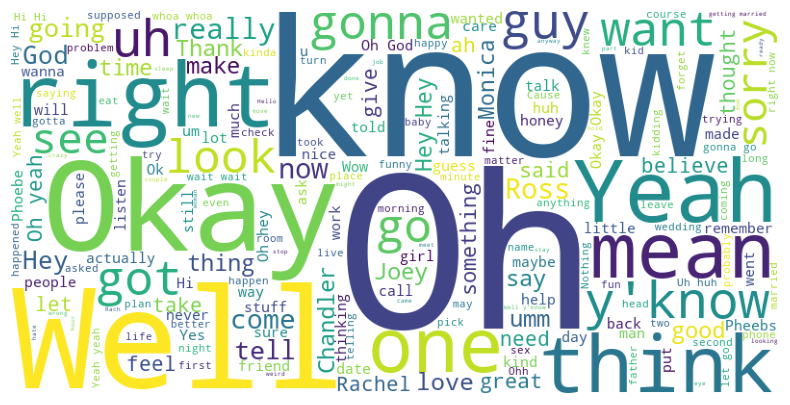

In [8]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [9]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [10]:
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_6')
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_456')
display_dialogue(dataframe=df.drop(columns='speaker_and_utterances'), utterance_id='utterance_2005')

### Removing NaN Values

Utterance 6


,speakers,emotions,utterances,triggers
0,Joey,surprise,But then who? The waitress I went out with las...,0.0
1,Rachel,sadness,You know? Forget it!,0.0
2,Joey,surprise,"No-no-no-no, no! Who, who were you talking about?",0.0
3,Rachel,fear,"No, I-I-I-I don't, I actually don't know",0.0
4,Joey,neutral,Ok!,1.0
5,Joey,neutral,"All right, well...",1.0
6,Rachel,neutral,"Yeah, sure!",0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Analyzing the dataset

In [11]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


In [12]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Appling some preprocessing operations 


### Splitting the dataset 

In [13]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df.head())

print("\nValidation Set: ")
display(val_df.head())

print("\nTest Set: ")
display(test_df.head())


Training Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_3183,"[Monica, Chandler, Chandler, Chandler, Monica,...","[fear, neutral, neutral, neutral, anger, neutr...","[I'm so sorry. Please, stop freaking out., I'm...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Monica: I'm so sorry. Please, stop freaking o..."
utterance_2330,"[Joey, Monica, Joey, Ross, Joey]","[sadness, neutral, sadness, neutral, neutral]","[Awww! Mel Torme died., Joey, that paper's lik...","[0.0, 0.0, 0.0, 1.0, 0.0]","[Joey: Awww! Mel Torme died., Monica: Joey, th..."
utterance_3223,"[Monica, Chandler, Monica]","[joy, neutral, neutral]","[That really was some of your best work., Hm-h...","[0.0, 1.0, 0.0]",[Monica: That really was some of your best wor...
utterance_1232,"[Phoebe, Rachel, Monica, Phoebe]","[sadness, surprise, surprise, neutral]","[Well yeah, I lied before., Oh!, Oh God, Now y...","[0.0, 1.0, 1.0, 0.0]","[Phoebe: Well yeah, I lied before., Rachel: Oh..."
utterance_1193,"[Joey, Chandler, Chandler, Joey, Chandler]","[neutral, neutral, sadness, neutral, fear]","[Hello., Hey, it's me., I know you can't stand...","[0.0, 0.0, 0.0, 0.0, 1.0]","[Joey: Hello., Chandler: Hey, it's me., Chandl..."



Validation Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_203,"[Monica, Phoebe, Monica, Phoebe]","[neutral, joy, neutral, neutral]","[I know., Ooh, I have to tell you something., ...","[0.0, 0.0, 0.0, 1.0]","[Monica: I know., Phoebe: Ooh, I have to tell ..."
utterance_2666,"[Phoebe, The Lurker, Phoebe, The Lurker, The S...","[surprise, anger, anger, anger, neutral, disgu...","[I won! I won! I finally won!, I won! That was...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[Phoebe: I won! I won! I finally won!, The Lur..."
utterance_892,"[Phoebe, Phoebe, Phoebe]","[anger, sadness, neutral]",[Oh... Mike's sister just invited me to a part...,"[0.0, 0.0, 0.0]",[Phoebe: Oh... Mike's sister just invited me t...
utterance_542,"[Ross, Ross, Ross, Phoebe, Ross, Phoebe, Monic...","[neutral, joy, neutral, neutral, joy, neutral,...","[No real-, honey, really it's fine, just g-go ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[Ross: No real-, honey, really it's fine, just..."
utterance_139,"[Monica, Joey, Monica, Joey]","[neutral, joy, joy, disgust]","[Okay, we have a lot of options here, a number...","[0.0, 0.0, 0.0, 0.0]","[Monica: Okay, we have a lot of options here, ..."



Test Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_229,"[Phoebe, Rachel, Phoebe]","[neutral, neutral, surprise]",[Personal shopping? What is that? Like where y...,"[0.0, 1.0, 0.0]",[Phoebe: Personal shopping? What is that? Like...
utterance_3692,"[Ross, Rachel, Ross, Ross]","[neutral, joy, joy, neutral]","[Hey, so uh, y'know how there's something I wa...","[0.0, 0.0, 0.0, 1.0]","[Ross: Hey, so uh, y'know how there's somethin..."
utterance_1839,"[Joey, Chandler, Joey]","[neutral, anger, sadness]","[I'm telling you man, I saw it., Yeah, well, y...","[0.0, 1.0, 0.0]","[Joey: I'm telling you man, I saw it., Chandle..."
utterance_3621,"[Monica, The Food Critic, Monica, The Food Cri...","[neutral, surprise, neutral, joy, anger, joy]","[Hi! Umm, I'm Monica Geller, I'm the chef at A...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Monica: Hi! Umm, I'm Monica Geller, I'm the c..."
utterance_3180,"[Monica, Chandler, Chandler, Chandler, Monica,...","[fear, neutral, neutral, neutral, anger, neutr...","[I'm so sorry. Please, stop freaking out., I'm...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[Monica: I'm so sorry. Please, stop freaking o..."


### Visualizing the classes distribution over the datasets

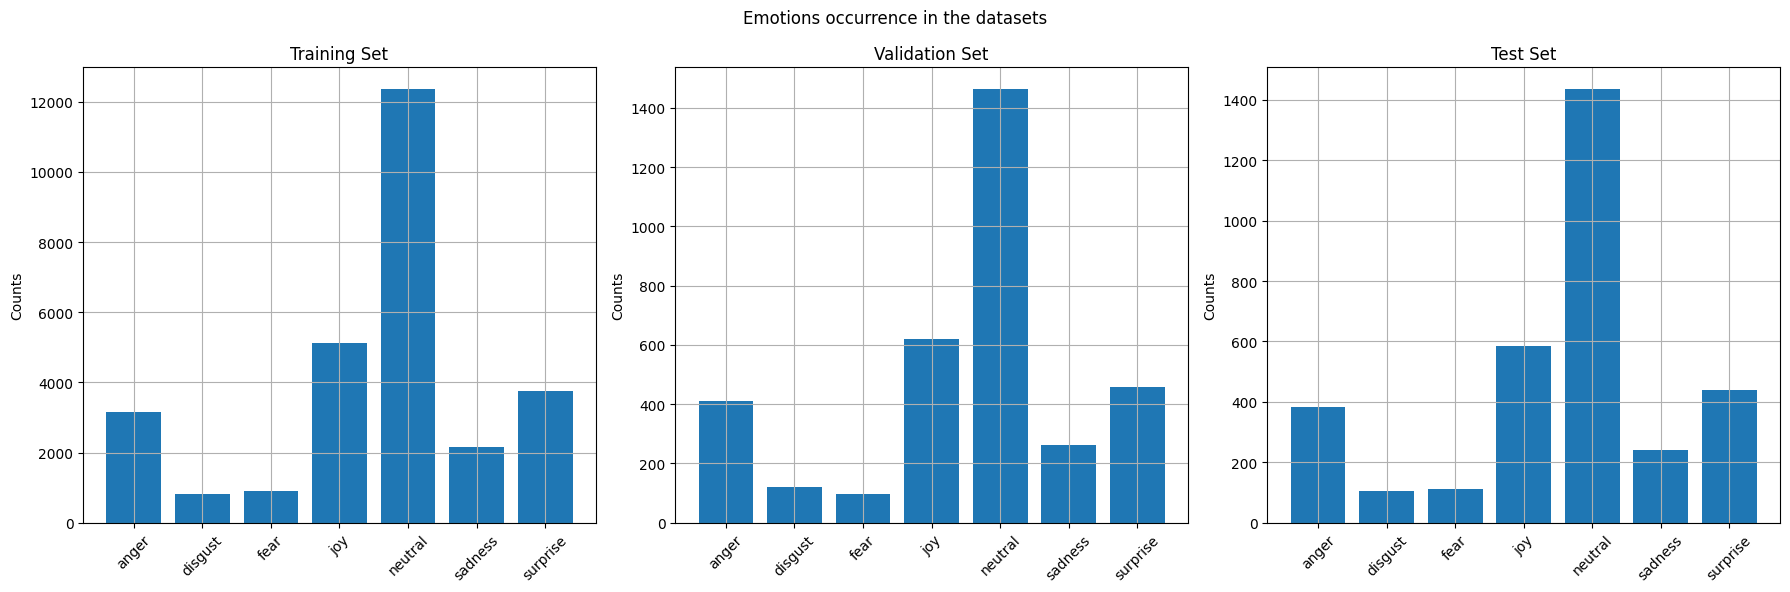

In [14]:
plot_emotion_distribution(train_df, val_df, test_df)


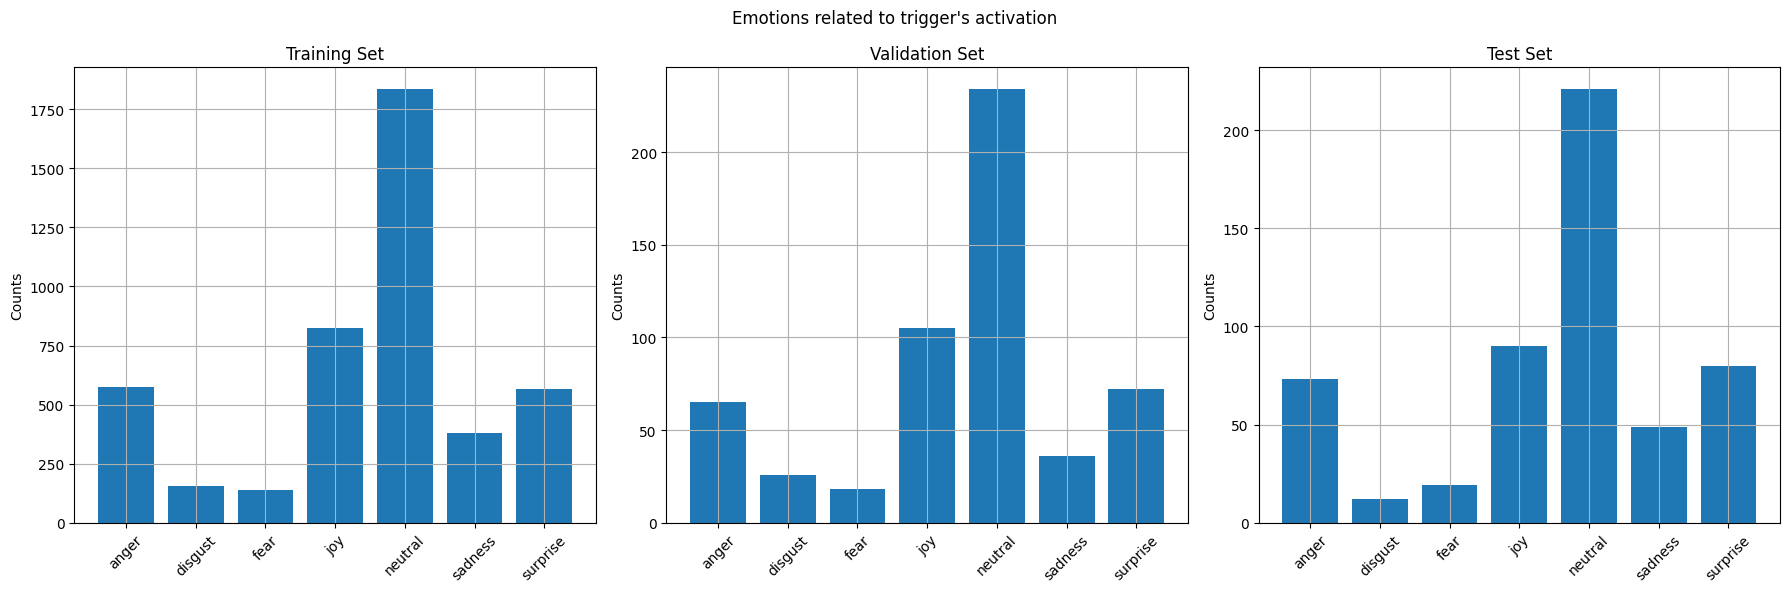

In [15]:
# How many times each emotion activates a trigger
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [16]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594761
1,1.0,3.138206
2,2.0,0.000000


## Random Classifier

In [17]:
# todo metric computation
if RUN_RANDOM_CLF:

    emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
    random_classifier = RandomClassifier(emotions)
    
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df.drop(columns='speaker_and_utterances'), utterance_id=0)  


Utterance_0


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Phoebe,neutral,Personal shopping? What is that? Like where yo...,0.0,joy,0
1,Rachel,neutral,Uh-huh.,1.0,disgust,1
2,Phoebe,surprise,That sounds great!,0.0,fear,0


## Majority Classifier

In [18]:
# todo metrics computation
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    # esempio di print per gli scettici che non crederanno che il classifier funziona
    new_test_df = test_df.copy()
    new_test_df['pred_emotions'] = pred_emotions
    new_test_df['pred_triggers'] = pred_triggers
    display_dialogue(dataframe=new_test_df, utterance_id=0)


Utterance_0


,speakers,emotions,utterances,triggers,speaker_and_utterances,pred_emotions,pred_triggers
0,Phoebe,neutral,Personal shopping? What is that? Like where yo...,0.0,Phoebe: Personal shopping? What is that? Like ...,neutral,0.0
1,Rachel,neutral,Uh-huh.,1.0,Rachel: Uh-huh.,neutral,0.0
2,Phoebe,surprise,That sounds great!,0.0,Phoebe: That sounds great!,neutral,0.0


## Bert Models

In [19]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


#### Creating Data Loaders

In [20]:
max_tokenized_length_su = find_max_encoded_utterance(bert_tokenizer, df['speaker_and_utterances'])
max_tokenized_length = find_max_encoded_utterance(bert_tokenizer, df['utterances'])

my_tokenization_f_su = partial(tokenize_data, max_tokenized_length=max_tokenized_length_su, tokenizer=bert_tokenizer)
my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)
 
dataLoaderBuilder = DataLoaderFromPipelineStrategy()

train_su_dataloader = dataLoaderBuilder.create(data=train_df["speaker_and_utterances"],
                                            labels=train_df[["emotions", "triggers"]],
                                            shuffle=True,
                                            data_preprocess_f=my_tokenization_f_su,
                                            labels_preprocess_f=preprocess_labels,
                                            batch_size=32,
                                            device=device)
 
val_su_dataloader = dataLoaderBuilder.create(data=val_df["speaker_and_utterances"],
                                          labels=val_df[["emotions", "triggers"]],
                                          shuffle=False,
                                          data_preprocess_f=my_tokenization_f_su,
                                          labels_preprocess_f=preprocess_labels,
                                          batch_size=32,
                                          device=device)
 
test_su_dataloader = dataLoaderBuilder.create(data=test_df["speaker_and_utterances"],
                                           labels=test_df[["emotions", "triggers"]],
                                           shuffle=False,
                                           data_preprocess_f=my_tokenization_f_su,
                                           labels_preprocess_f=preprocess_labels,
                                           batch_size=32,
                                           device=device)
   
   
train_dataloader = dataLoaderBuilder.create(data=train_df["utterances"],
                                            labels=train_df[["emotions", "triggers"]],
                                            shuffle=True,
                                            data_preprocess_f=my_tokenization_f,
                                            labels_preprocess_f=preprocess_labels,
                                            batch_size=32,
                                            device=device)
 
val_dataloader = dataLoaderBuilder.create(data=val_df["utterances"],
                                          labels=val_df[["emotions", "triggers"]],
                                          shuffle=False,
                                          data_preprocess_f=my_tokenization_f,
                                          labels_preprocess_f=preprocess_labels,
                                          batch_size=32,
                                          device=device)
 
test_dataloader = dataLoaderBuilder.create(data=test_df["utterances"],
                                           labels=test_df[["emotions", "triggers"]],
                                           shuffle=False,
                                           data_preprocess_f=my_tokenization_f,
                                           labels_preprocess_f=preprocess_labels,
                                           batch_size=32,
                                           device=device)   
   
 
input_data_su, _ = next(iter(train_su_dataloader))
input_data, _ = next(iter(train_dataloader))
n_token_per_utterance_su = input_data_su['input_ids'].shape[-1]
n_token_per_utterance = input_data['input_ids'].shape[-1]


### Defining Metrics and Criterion

In [ ]:
#Losses definitions and combination
emotion_criterion = Criterion(name='emotion_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  # weight=torch.tensor(emotion_weights)

trigger_criterion = Criterion(name='trigger_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none'))  # weight=torch.tensor(trigger_weights)

multi_head_criterion = MultyHeadCriterion(name='agg_CE_loss',
                                          loss_functions={'emotions': emotion_criterion, 
                                                          'triggers': trigger_criterion},
                                          loss_weights=[1, 1],
                                          reduction_function=torch.mean)


##### Metrics definitions and combination

# F1 definition
emotion_f1 = F1_Score(name='emotion_F1',
                      mode='macro',
                      num_classes=len(padded_emotions),
                      classes_to_exclude=[8])     

trigger_f1 = F1_Score(name='triggers_F1',
                      mode='macro',
                      num_classes=len(padded_triggers),
                      classes_to_exclude=[2])     

multi_head_f1 = MultyHeadMetric(name='agg_avg_F1',
                                metrics_functions={'emotions': emotion_f1,
                                                   'triggers': trigger_f1},
                                metric_weights=[1, 1],
                                aggregate_metrics_function=torch.mean)


# Accuracy definition
emotion_accuracy = Accuracy(name='emotion_accuracy',
                            num_classes=len(padded_emotions),
                            classes_to_exclude=[8])     

trigger_accuracy = Accuracy(name='triggers_accuracy',
                            num_classes=len(padded_triggers),
                            classes_to_exclude=[2])     

multi_head_accuracy = MultyHeadMetric(name='agg_avg_accuracy',
                                      metrics_functions={'emotions': emotion_accuracy,
                                                         'triggers': trigger_accuracy},
                                      metric_weights=[1, 1],
                                      aggregate_metrics_function=torch.mean)


# Recall definition
emotion_recall = Recall(name='emotion_recall',
                        num_classes=len(padded_emotions),
                        classes_to_exclude=[8])     

trigger_recall = Recall(name='triggers_recall',
                        num_classes=len(padded_triggers),
                        classes_to_exclude=[2])     

multi_head_recall = MultyHeadMetric(name='agg_avg_recall',
                                    metrics_functions={'emotions': emotion_recall,
                                                       'triggers': trigger_recall},
                                    metric_weights=[1, 1],
                                    aggregate_metrics_function=torch.mean)


# Precision definition
emotion_precision = Precision(name='emotion_precision',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[8])     

trigger_precision = Precision(name='triggers_precision',
                              num_classes=len(padded_triggers),
                              classes_to_exclude=[2])     
      
multi_head_precision = MultyHeadMetric(name='agg_avg_precision',
                                       metrics_functions={'emotions': emotion_precision,
                                                          'triggers': trigger_precision},
                                       metric_weights=[1, 1],
                                       aggregate_metrics_function=torch.mean)
   


optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                             identifier=f'lr={1e-5}', 
                             optimizer_partial_params={'lr': 1e-5})  

early_stopper = EarlyStopper(monitor='agg_CE_loss', 
                             patience=PATIENCE, 
                             delta=0, 
                             mode='min',
                             restore_weights=True)
        

### Freezed Bert

#### Grid Search Freezed BertOne 

In [22]:
#todo grid 

#### Creating Freezed BertOne

In [27]:
torch.manual_seed(42)
np.random.seed(42)

freezed_bert_1 = BertOne(bert_model=bert_model,
                         n_emotions=len(padded_emotions),
                         n_triggers=len(padded_triggers),
                         cls_input_size=n_token_per_utterance_su*BERT_HIDDEN_DIM,
                         freeze_bert_weights=True).to(device)



####   Visualizing Net Structure 

In [38]:
freezed_bert_1.visualize_network_graph(input=input_data_su, 
                                       input_names=['tokenized utterances', 'token id', 'attention mask'],
                                       output_names=['emotions,triggers'])


#### Visualizing the summary 

In [41]:
freezed_bert_1.summary(input_data_su, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1             [32, 388, 768]      23,440,896
              Embedding-2             [32, 388, 768]           1,536
              Embedding-3             [32, 388, 768]         393,216
              LayerNorm-4             [32, 388, 768]           1,536
                Dropout-5             [32, 388, 768]               0
         BertEmbeddings-6             [32, 388, 768]               0
                 Linear-7             [32, 388, 768]         590,592
                 Linear-8             [32, 388, 768]         590,592
                 Linear-9             [32, 388, 768]         590,592
               Dropout-10         [32, 12, 388, 388]               0
     BertSelfAttention-11           [[-1, 388, 768]]               0
                Linear-12             [32, 388, 768]         590,592
               Dropout-13         

#### Fitting Freezed BertOne

In [30]:
if FIT_FREEZED_BERTONE:

    freezed_bert_1_history = freezed_bert_1.fit(train_loader=train_su_dataloader,
                                                val_loader=val_su_dataloader,
                                                criterion=multi_head_criterion,
                                                metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                                optimizer=optimizer,
                                                early_stopper=early_stopper,
                                                num_epochs=10)
        
    torch.save(freezed_bert_1.state_dict(), FREEZED_BERTONE_WEIGHTS_PATH)

else:
    freezed_bert_1.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))
    freezed_bert_1_history = None
    

FileNotFoundError: [Errno 2] No such file or directory: 'results\\weights\\freezed_bertone_weights.pth'

#### Visualizing training history  

In [31]:
if FIT_FREEZED_BERTONE:
    plot_history(freezed_bert_1_history, patience=PATIENCE)
else:
    print("To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True ")
    

To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True 


### Full Bert

#### Grid Search Full BertOne 

In [ ]:
# todo grid search

#### Creating Full BertOne

In [32]:
full_bert_1 = BertOne(bert_model=bert_model,
                      n_emotions=len(padded_emotions),
                      n_triggers=len(padded_triggers),
                      cls_input_size=n_token_per_utterance_su*BERT_HIDDEN_DIM,
                      freeze_bert_weights=True).to(device)

#### Visualizing the summary 

In [42]:
full_bert_1.summary(input_data_su, verbose=True)

--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1             [32, 388, 768]      23,440,896
              Embedding-2             [32, 388, 768]           1,536
              Embedding-3             [32, 388, 768]         393,216
              LayerNorm-4             [32, 388, 768]           1,536
                Dropout-5             [32, 388, 768]               0
         BertEmbeddings-6             [32, 388, 768]               0
                 Linear-7             [32, 388, 768]         590,592
                 Linear-8             [32, 388, 768]         590,592
                 Linear-9             [32, 388, 768]         590,592
               Dropout-10         [32, 12, 388, 388]               0
     BertSelfAttention-11           [[-1, 388, 768]]               0
                Linear-12             [32, 388, 768]         590,592
               Dropout-13         

#### Fitting Freezed BertOne

In [34]:
if FIT_FULL_BERTONE:

    full_bert_1_history = full_bert_1.fit(train_loader=train_su_dataloader,
                                          val_loader=val_su_dataloader,
                                          criterion=multi_head_criterion,
                                          metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                          optimizer=optimizer,
                                          early_stopper=early_stopper,
                                          num_epochs=10)
        
    torch.save(full_bert_1.state_dict(), FULL_BERTONE_WEIGHTS_PATH)

else:
    full_bert_1.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))
    full_bert_1_history = None
        

FileNotFoundError: [Errno 2] No such file or directory: 'results\\weights\\full_bertone_weights.pth'

#### Visualizing training history  

In [35]:
if FIT_FULL_BERTONE:
    plot_history(full_bert_1_history, patience=PATIENCE)
else:
    print("To show the training history of Full BERT base model  you should set the flag FIT_FULL_BERTONE=True ")

To show the training history of Full BERT base model  you should set the flag FIT_FULL_BERTONE=True 
